# Exploring Breast Cancer Diagnosis Stage in NY State

## Set Up

In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Tidycensus connect

In [4]:
%%R 

library(tidycensus)
library(tidyverse)
library(sf)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linking to GEOS 3.13.0, GDAL 3.10.2, PROJ 9.5.1; sf_use_s2() is TRUE


In [5]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

In [6]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Getting the Census Dataset I want

In [7]:
%%R 

# this code is incomplete, refer to example notebooks
# and use chat gpt for help getting census variables
ny_census_data <- get_acs(geography = "county", 
                      state='NY',
                      variables = c(
                          # education
                          female_25_pop = "B15002_019", #total female population 25 and older
                        bachelors = "B15002_032", #  bachelors degree female
                          masters = "B15002_033", #masters degree females
                          doctorate = "B15002_035", #doctorate degree females
                          
                          #poverty and income
                          total_population_poverty = "B17001_001", #total population under poverty
                          female_poverty = "B17001_017", #female population under poverty
                          
                          med_inc = "B19013_001", # median household income
                          
                          #race - doesn't have gender
                            white_pop = "B01001A_017", # white alone females
                           black_pop = "B01001B_017", #black alone females
                           hispanic_latino = "B01001I_017", #hispanic or latino alone females
                          
                          #population
                         total_pop = "B01001_001",  #Total population
                         female_pop = "B01001_026" #Total female population
                      ), 
                      year = 2021,
                      survey="acs5",
                      geometry=T)
                   

ny_census_data

Simple feature collection with 744 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -79.76215 ymin: 40.4961 xmax: -71.85621 ymax: 45.01585
Geodetic CRS:  NAD83
First 10 features:
   GEOID                      NAME                 variable estimate moe
1  36017 Chenango County, New York                total_pop    47407  NA
2  36017 Chenango County, New York               female_pop    23587  51
3  36017 Chenango County, New York                white_pop    22527 106
4  36017 Chenango County, New York                black_pop      165  58
5  36017 Chenango County, New York          hispanic_latino      469  18
6  36017 Chenango County, New York            female_25_pop    17050  62
7  36017 Chenango County, New York                bachelors     1767 222
8  36017 Chenango County, New York                  masters     1460 203
9  36017 Chenango County, New York                doctorate       76  40
10 36017 Chenango County, New York total_population

Getting data from the 2017-2021 5-year ACS
Using FIPS code '36' for state 'NY'


### Load our breast cancer rates 

In [8]:
df = pd.read_csv("breast_cancer_stages_NY.csv")
df.head()

,County,Stage,Percent
0,Broome,Local,73.9
1,Cattaraugus,Local,69.3
2,Cayuga,Local,74.8
3,Chautauqua,Local,72.0
4,Chemung,Local,65.6


In [9]:
breast_cancer_ny = df.pivot_table(index="County", 
                             columns="Stage", 
                             values="Percent")

breast_cancer_ny = breast_cancer_ny.reset_index()
breast_cancer_ny.columns.name = None


breast_cancer_ny.head()

,County,Distant,Local,Regional,Unknown
0,Albany,4.9,71.3,22.5,1.4
1,Allegany,6.3,74.4,17.0,2.3
2,Bronx,7.6,61.4,28.1,2.8
3,Broome,4.6,73.9,20.3,1.2
4,Cattaraugus,7.5,69.3,20.9,2.3


## Clean Up Our Census Data

In [10]:
%%R 
#pivot wider
# moe is margin of error

ny_census_data <- ny_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

ny_census_data

Simple feature collection with 62 features and 26 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -79.76215 ymin: 40.4961 xmax: -71.85621 ymax: 45.01585
Geodetic CRS:  NAD83
# A tibble: 62 × 27
   GEOID NAME                    geometry total_pop_estimate female_pop_estimate
   <chr> <chr>         <MULTIPOLYGON [°]>              <dbl>               <dbl>
 1 36017 Chena… (((-75.88983 42.72384, -…              47407               23587
 2 36119 Westc… (((-73.77278 40.8846, -7…             999723              512430
 3 36025 Delaw… (((-75.42264 42.05591, -…              44644               22004
 4 36115 Washi… (((-73.63622 43.49824, -…              61504               29428
 5 36075 Osweg… (((-76.61693 43.41804, -…             118019               58647
 6 36067 Onond… (((-76.49931 43.09795, -…             474621              244319
 7 36113 Warre… (((-74.21462 43.7287, -7…              65692               33195
 8 36051 Livin… (((-78.06075 42.53671, -…          

In [11]:
%%R

#name it be the same name as the county in our dataset

ny_census_data <- ny_census_data %>%
    mutate(
        county = str_split(NAME, " ") %>% map_chr(1) %>% str_trim(),
    )

In [12]:
%%R
ny_census_data %>% 
    select(NAME, county)

Simple feature collection with 62 features and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -79.76215 ymin: 40.4961 xmax: -71.85621 ymax: 45.01585
Geodetic CRS:  NAD83
# A tibble: 62 × 3
   NAME                         county                                  geometry
   <chr>                        <chr>                         <MULTIPOLYGON [°]>
 1 Chenango County, New York    Chenango    (((-75.88983 42.72384, -75.82109 42…
 2 Westchester County, New York Westchester (((-73.77278 40.8846, -73.77228 40.…
 3 Delaware County, New York    Delaware    (((-75.42264 42.05591, -75.42262 42…
 4 Washington County, New York  Washington  (((-73.63622 43.49824, -73.63453 43…
 5 Oswego County, New York      Oswego      (((-76.61693 43.41804, -76.60709 43…
 6 Onondaga County, New York    Onondaga    (((-76.49931 43.09795, -76.49922 43…
 7 Warren County, New York      Warren      (((-74.21462 43.7287, -74.05875 43.…
 8 Livingston County, New York  Livingston  (((-78.06

In [13]:
%%R -o ny_census_data_py

ny_census_data_py <- ny_census_data %>%
  st_drop_geometry() %>%  # Remove the spatial geometry
  as.data.frame()  


In [14]:
ny_census_data_py.head()

,GEOID,NAME,total_pop_estimate,female_pop_estimate,white_pop_estimate,black_pop_estimate,hispanic_latino_estimate,female_25_pop_estimate,bachelors_estimate,masters_estimate,doctorate_estimate,total_population_poverty_estimate,female_poverty_estimate,med_inc_estimate,total_pop_moe,female_pop_moe,white_pop_moe,black_pop_moe,hispanic_latino_moe,female_25_pop_moe,bachelors_moe,masters_moe,doctorate_moe,total_population_poverty_moe,female_poverty_moe,med_inc_moe,county
1,36017,"Chenango County, New York",47407.0,23587.0,22527.0,165.0,469.0,17050.0,1767.0,1460.0,76.0,46485.0,3064.0,55690.0,NaN,51.0,106.0,58.0,18.0,62.0,222.0,203.0,40.0,200.0,414.0,2603.0,Chenango
2,36119,"Westchester County, New York",999723.0,512430.0,305862.0,78031.0,125028.0,362368.0,91387.0,73613.0,7458.0,977049.0,47101.0,105387.0,NaN,113.0,2180.0,1116.0,NaN,117.0,1829.0,2092.0,737.0,1158.0,2262.0,1643.0,Westchester
3,36025,"Delaware County, New York",44644.0,22004.0,20592.0,328.0,928.0,16507.0,2199.0,1683.0,202.0,42407.0,3495.0,52757.0,NaN,92.0,116.0,120.0,58.0,100.0,225.0,203.0,87.0,321.0,462.0,2293.0,Delaware
4,36115,"Washington County, New York",61504.0,29428.0,28025.0,147.0,491.0,21825.0,2860.0,1928.0,146.0,57960.0,3945.0,63869.0,NaN,147.0,196.0,112.0,55.0,115.0,359.0,272.0,59.0,379.0,579.0,2006.0,Washington
5,36075,"Oswego County, New York",118019.0,58647.0,55112.0,611.0,1669.0,40546.0,4975.0,3875.0,207.0,112316.0,10027.0,61983.0,NaN,167.0,245.0,159.0,96.0,76.0,364.0,362.0,124.0,493.0,863.0,2218.0,Oswego


## Join our Breast Cancer dataset and Census

In [15]:
merged_df = breast_cancer_ny.merge(ny_census_data_py, left_on = "County", right_on = "county", how = "left")

merged_df.head()

,County,Distant,Local,Regional,Unknown,GEOID,NAME,total_pop_estimate,female_pop_estimate,white_pop_estimate,black_pop_estimate,hispanic_latino_estimate,female_25_pop_estimate,bachelors_estimate,masters_estimate,doctorate_estimate,total_population_poverty_estimate,female_poverty_estimate,med_inc_estimate,total_pop_moe,female_pop_moe,white_pop_moe,black_pop_moe,hispanic_latino_moe,female_25_pop_moe,bachelors_moe,masters_moe,doctorate_moe,total_population_poverty_moe,female_poverty_moe,med_inc_moe,county
0,Albany,4.9,71.3,22.5,1.4,36001,"Albany County, New York",314679.0,161680.0,119025.0,19638.0,10120.0,109992.0,23543.0,18813.0,2564.0,298762.0,19093.0,73810.0,NaN,83.0,604.0,965.0,NaN,67.0,959.0,1077.0,367.0,902.0,1321.0,2387.0,Albany
1,Allegany,6.3,74.4,17.0,2.3,36003,"Allegany County, New York",46654.0,23052.0,21891.0,377.0,535.0,15076.0,2020.0,1584.0,112.0,41571.0,3486.0,54375.0,NaN,128.0,74.0,96.0,60.0,88.0,252.0,163.0,26.0,422.0,372.0,1505.0,Allegany
2,Bronx,7.6,61.4,28.1,2.8,36005,"Bronx County, New York",1468262.0,772461.0,153016.0,269597.0,434648.0,522309.0,73429.0,36184.0,3162.0,1433574.0,215657.0,43726.0,NaN,215.0,4224.0,3029.0,NaN,244.0,2512.0,1584.0,532.0,1399.0,4979.0,745.0,Bronx
3,Broome,4.6,73.9,20.3,1.2,36007,"Broome County, New York",198591.0,100258.0,84435.0,5537.0,4447.0,67946.0,9949.0,7596.0,991.0,188745.0,19080.0,53982.0,NaN,42.0,398.0,439.0,NaN,23.0,643.0,566.0,239.0,1033.0,1257.0,1835.0,Broome
4,Cattaraugus,7.5,69.3,20.9,2.3,36009,"Cattaraugus County, New York",77211.0,38525.0,35041.0,351.0,725.0,26797.0,2948.0,2686.0,122.0,74788.0,6814.0,53537.0,NaN,96.0,117.0,90.0,52.0,69.0,234.0,281.0,58.0,346.0,571.0,1681.0,Cattaraugus


In [16]:
merged_df.shape

(62, 32)

In [17]:
#merged_df.drop(columns = ["NAME","county"], axis = 1, inplace = True)

## Analysis

First we need to calculate some percentages before we can run linear regressions.

In [18]:
merged_df[merged_df["County"] == "Albany"]

,County,Distant,Local,Regional,Unknown,GEOID,NAME,total_pop_estimate,female_pop_estimate,white_pop_estimate,black_pop_estimate,hispanic_latino_estimate,female_25_pop_estimate,bachelors_estimate,masters_estimate,doctorate_estimate,total_population_poverty_estimate,female_poverty_estimate,med_inc_estimate,total_pop_moe,female_pop_moe,white_pop_moe,black_pop_moe,hispanic_latino_moe,female_25_pop_moe,bachelors_moe,masters_moe,doctorate_moe,total_population_poverty_moe,female_poverty_moe,med_inc_moe,county
0,Albany,4.9,71.3,22.5,1.4,36001,"Albany County, New York",314679.0,161680.0,119025.0,19638.0,10120.0,109992.0,23543.0,18813.0,2564.0,298762.0,19093.0,73810.0,NaN,83.0,604.0,965.0,NaN,67.0,959.0,1077.0,367.0,902.0,1321.0,2387.0,Albany


In [19]:
# percent of women above 25 that have a higher degree (should I include professional?)
merged_df["pct_higher_ed"] = ((merged_df["bachelors_estimate"] + merged_df["masters_estimate"] + merged_df["doctorate_estimate"]) / merged_df["female_25_pop_estimate"]) * 100

In [20]:
# percent of females in poverty 
merged_df["pct_female_poverty"] = (merged_df["female_poverty_estimate"] / merged_df["female_pop_estimate"]) * 100

In [21]:
# percentage race 
merged_df["pct_white"] = (merged_df["white_pop_estimate"] / merged_df["female_pop_estimate"]) * 100
merged_df["pct_black"] = (merged_df["black_pop_estimate"] / merged_df["female_pop_estimate"]) * 100
merged_df["pct_hisp_lat"] = (merged_df["hispanic_latino_estimate"] / merged_df["female_pop_estimate"]) * 100

In [22]:
# making a new dataframe with just the analysis variables 

clean_df = merged_df[["County", "Distant", "Local","Regional","Unknown", "med_inc_estimate", "pct_higher_ed", "pct_female_poverty","pct_white","pct_black","pct_hisp_lat"]]
clean_df.head()

,County,Distant,Local,Regional,Unknown,med_inc_estimate,pct_higher_ed,pct_female_poverty,pct_white,pct_black,pct_hisp_lat
0,Albany,4.9,71.3,22.5,1.4,73810.0,40.839334,11.809129,73.617640,12.146215,6.259278
1,Allegany,6.3,74.4,17.0,2.3,54375.0,24.648448,15.122332,94.963561,1.635433,2.320840
2,Bronx,7.6,61.4,28.1,2.8,43726.0,21.591625,27.918173,19.808897,34.901050,56.267954
3,Broome,4.6,73.9,20.3,1.2,53982.0,27.280487,19.030900,84.217718,5.522751,4.435556
4,Cattaraugus,7.5,69.3,20.9,2.3,53537.0,21.480016,17.687216,90.956522,0.911097,1.881895


## Run Linear Regressions in R

I want to see if the stage at which diagnosis happens can be predicted by some socioeconomic factors. Local stage is when the cancer is spreading but still localised to the breast i.e Early Stage. Distant stage is when the cancer has spread far and wide and has almost taken over the organs i.e. Late Stage. 

Y1 = Percent of population in the county diagnosed at Local Stage

Y2 = Percent of population in the county diagnosed at Distant Stage 

**We will run these against a bunch of Xs**

X1 = Higher Education Attainment

X2 = Poverty Level

X3 = Median Household Income

X4 = Race (white, black, hisp_lat) - separately? need clarity on this one

### Local ( Y1 ) ~ X ( 1,2,3... )

In [23]:
%%R -i clean_df

model <- lm(Local~pct_higher_ed, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_higher_ed, data = clean_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.3295  -1.8844   0.3276   2.0165   9.9996 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   69.76931    2.20159  31.690   <2e-16 ***
pct_higher_ed -0.01186    0.07183  -0.165    0.869    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.152 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.00047,	Adjusted R-squared:  -0.01676 
F-statistic: 0.02727 on 1 and 58 DF,  p-value: 0.8694



In [24]:
## why are two observations deleted?

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



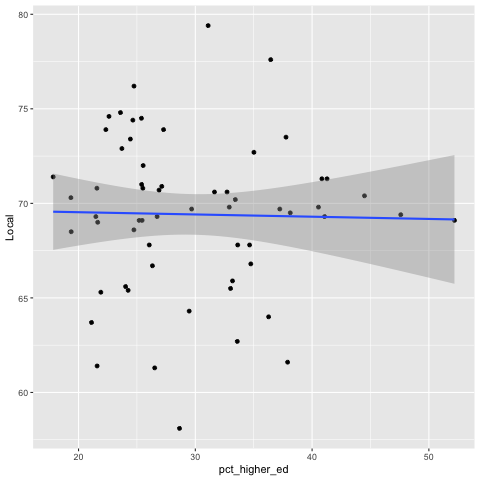

In [25]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_higher_ed, y=Local) + 
    geom_point() +
    geom_smooth(method='lm')

**Literally no correlation**

In [26]:
%%R -i clean_df

model <- lm(Local~pct_female_poverty, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_female_poverty, data = clean_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.6279  -2.6791   0.1009   2.3754   9.7829 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         72.1801     1.9840  36.381   <2e-16 ***
pct_female_poverty  -0.2083     0.1441  -1.445    0.154    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.08 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.03474,	Adjusted R-squared:  0.01809 
F-statistic: 2.087 on 1 and 58 DF,  p-value: 0.1539



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



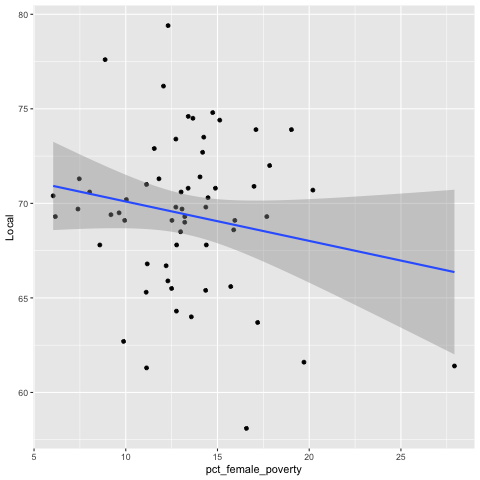

In [27]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_female_poverty, y=Local) + 
    geom_point() +
    geom_smooth(method='lm')

In [28]:
# Thoughts = maybe I should get individual years of diagnosis stages and then see if that works

In [29]:
%%R -i clean_df

model <- lm(Local~med_inc_estimate, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ med_inc_estimate, data = clean_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2998  -1.8753   0.1804   1.9020   9.9959 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      6.915e+01  2.320e+00   29.80   <2e-16 ***
med_inc_estimate 4.015e-06  3.340e-05    0.12    0.905    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.153 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.0002492,	Adjusted R-squared:  -0.01699 
F-statistic: 0.01446 on 1 and 58 DF,  p-value: 0.9047



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



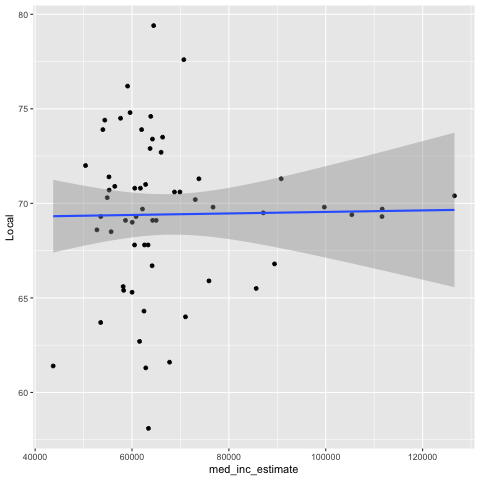

In [30]:
%%R 

ggplot(clean_df) + 
    aes(x=med_inc_estimate, y=Local) + 
    geom_point() +
    geom_smooth(method='lm')

In [31]:
%%R -i clean_df

model <- lm(Local~pct_white, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_white, data = clean_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.7300  -1.8931   0.3453   2.5209   8.9953 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 60.73208    2.80251  21.671  < 2e-16 ***
pct_white    0.10350    0.03287   3.148  0.00259 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.838 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.146,	Adjusted R-squared:  0.1312 
F-statistic: 9.913 on 1 and 58 DF,  p-value: 0.002593



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



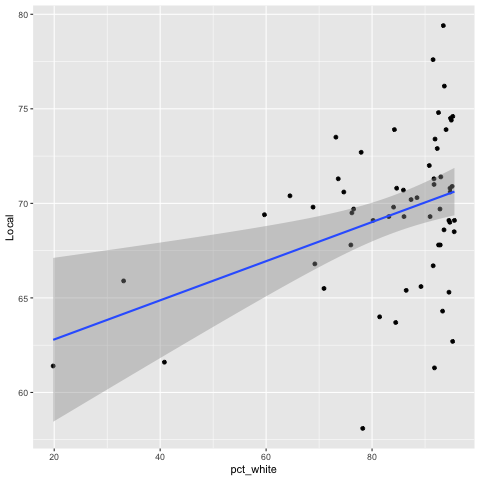

In [32]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_white, y=Local) + 
    geom_point() +
    geom_smooth(method='lm')

In [33]:
%%R
require(ggrepel)

Loading required package: ggrepel


In [34]:
%%R 

nyc_counties <- c("Bronx", "Kings", "New York", "Queens", "Richmond")
clean_df <- clean_df %>%
  mutate(is_nyc = County %in% nyc_counties)

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 

R[write to console]: 3: Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`). 

R[write to console]: 4: ggrepel: 33 unlabeled data points (too many overlaps). Consider increasing max.overlaps 



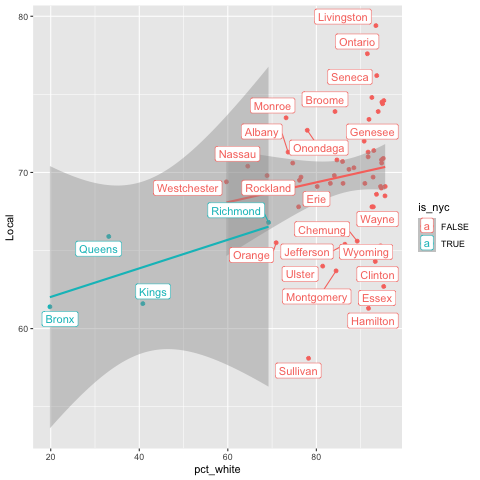

In [35]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_white, y=Local, color = is_nyc) + 
    geom_point() +
    geom_smooth(method='lm') +
    geom_label_repel(aes(label = County))

In [36]:
%%R 

model <- lm(Local~pct_black, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_black, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.784  -1.922   0.319   2.162   9.085 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  70.5551     0.6417 109.943  < 2e-16 ***
pct_black    -0.2063     0.0724  -2.849  0.00606 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.89 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1228,	Adjusted R-squared:  0.1077 
F-statistic: 8.118 on 1 and 58 DF,  p-value: 0.006057



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



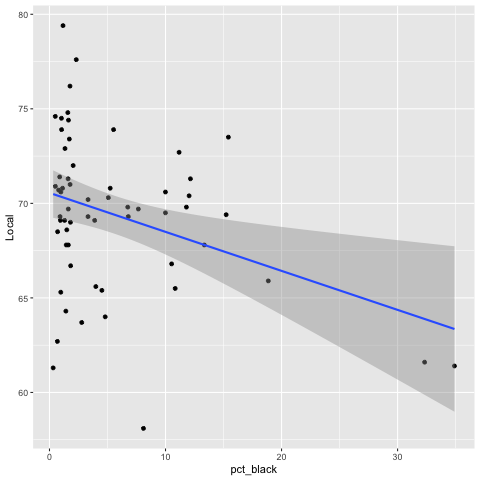

In [37]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_black, y=Local) + 
    geom_point() +
    geom_smooth(method='lm')

In [38]:
%%R 

model <- lm(Local~pct_hisp_lat, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_hisp_lat, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.7427 -1.5857  0.2899  2.5707  9.2085 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  70.84880    0.63805 111.040  < 2e-16 ***
pct_hisp_lat -0.18886    0.05426  -3.481 0.000957 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.777 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1728,	Adjusted R-squared:  0.1585 
F-statistic: 12.11 on 1 and 58 DF,  p-value: 0.0009571



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 

R[write to console]: 3: Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`). 

R[write to console]: 4: ggrepel: 40 unlabeled data points (too many overlaps). Consider increasing max.overlaps 



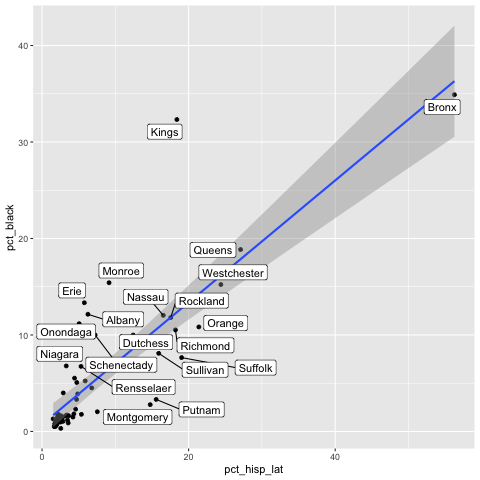

In [39]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_hisp_lat, y=pct_black) + 
    geom_point() +
    geom_smooth(method='lm') +
    geom_label_repel(aes(label = County))

### Distant ( Y2 ) ~ X ( 1,2,3... )

After those disappointing regressions - let's try the late stage diagnosis

In [40]:
%%R 

model <- lm(Distant~pct_higher_ed, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_higher_ed, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0449 -1.2330 -0.0772  0.7201  7.1263 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    6.83864    0.96998   7.050 2.41e-09 ***
pct_higher_ed -0.04015    0.03165  -1.269     0.21    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.829 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.027,	Adjusted R-squared:  0.01023 
F-statistic:  1.61 on 1 and 58 DF,  p-value: 0.2096



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



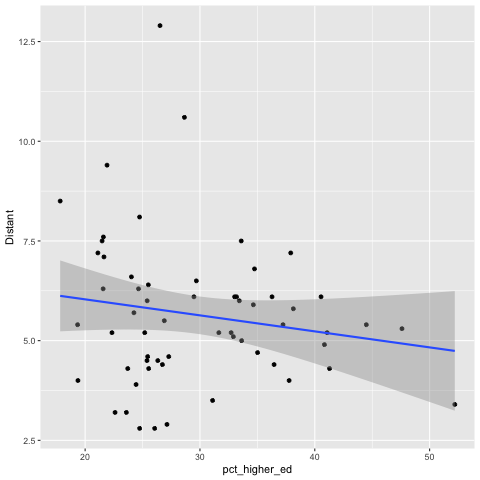

In [41]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_higher_ed, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [42]:
%%R 

model <- lm(Distant~pct_female_poverty, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_female_poverty, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0275 -1.0916 -0.0315  0.6355  7.4172 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.63772    0.89126   5.204 2.68e-06 ***
pct_female_poverty  0.07591    0.06475   1.172    0.246    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.833 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.02314,	Adjusted R-squared:  0.006302 
F-statistic: 1.374 on 1 and 58 DF,  p-value: 0.2459



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



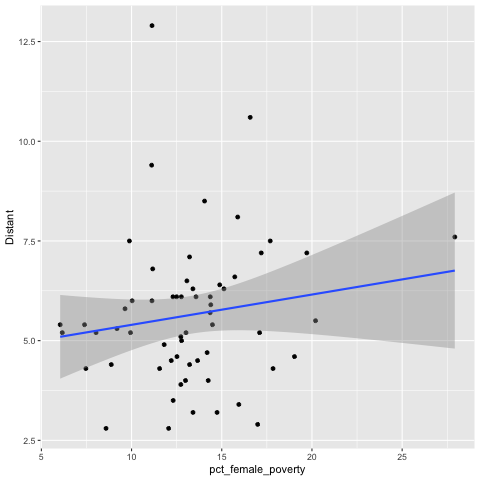

In [43]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_female_poverty, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [44]:
%%R 

model <- lm(Distant~med_inc_estimate, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ med_inc_estimate, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9150 -1.1849 -0.0584  0.7099  7.2159 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       6.201e+00  1.034e+00   6.000 1.36e-07 ***
med_inc_estimate -8.228e-06  1.488e-05  -0.553    0.582    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.85 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.005247,	Adjusted R-squared:  -0.0119 
F-statistic: 0.3059 on 1 and 58 DF,  p-value: 0.5823



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



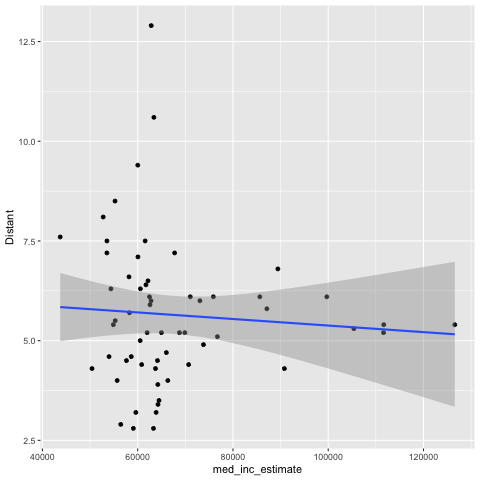

In [45]:
%%R 

ggplot(clean_df) + 
    aes(x=med_inc_estimate, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [46]:
%%R 

model <- lm(Distant~pct_white, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_white, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6678 -1.0707 -0.2384  0.7198  7.4106 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.30314    1.33600   5.466 1.01e-06 ***
pct_white   -0.01976    0.01567  -1.261    0.212    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.83 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.02668,	Adjusted R-squared:  0.009902 
F-statistic:  1.59 on 1 and 58 DF,  p-value: 0.2124



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



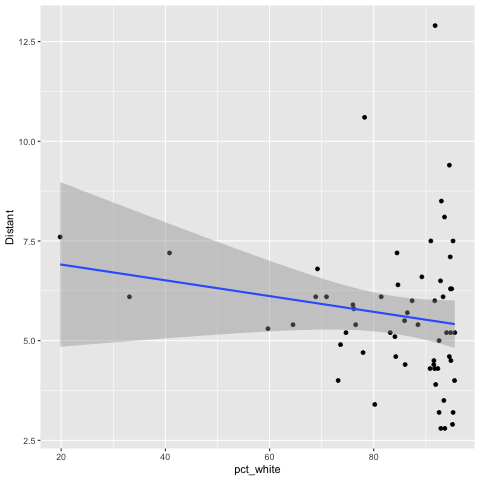

In [47]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_white, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [48]:
%%R 

model <- lm(Distant~pct_black, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_black, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7088 -1.1339 -0.2796  0.7730  7.4436 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.44477    0.30304  17.967   <2e-16 ***
pct_black    0.03628    0.03419   1.061    0.293    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.837 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.01905,	Adjusted R-squared:  0.002133 
F-statistic: 1.126 on 1 and 58 DF,  p-value: 0.293



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



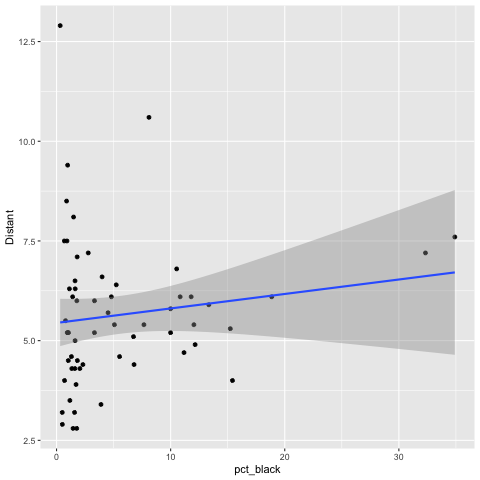

In [49]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_black, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [50]:
%%R 

model <- lm(Distant~pct_hisp_lat, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_hisp_lat, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6140 -1.0643 -0.2268  0.7333  7.4792 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.30692    0.30561  17.365   <2e-16 ***
pct_hisp_lat  0.04458    0.02599   1.715   0.0916 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.809 on 58 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.04829,	Adjusted R-squared:  0.03188 
F-statistic: 2.943 on 1 and 58 DF,  p-value: 0.09161



`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`). 

R[write to console]: 2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 



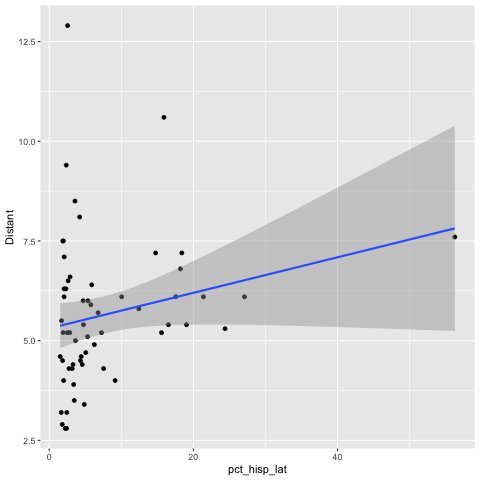

In [51]:
%%R 

ggplot(clean_df) + 
    aes(x=pct_hisp_lat, y=Distant) + 
    geom_point() +
    geom_smooth(method='lm')

In [52]:
# Maybe you have to take the outliers and then see over the years if the population or something has predicted it?

### Quick Multi Linear : Local ( Y1 ) ~ (X1 + X2 + X3...)

In [53]:
%%R 

upstate_df <- clean_df %>%
    filter(is_nyc == FALSE)

In [54]:
%%R 

model <- lm(Local~pct_white, data=upstate_df)
summary(model)


Call:
lm(formula = Local ~ pct_white, data = upstate_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.1533  -1.6830   0.3865   2.0990   9.1809 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 64.28671    5.20603  12.349   <2e-16 ***
pct_white    0.06348    0.05954   1.066    0.291    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.92 on 54 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.02062,	Adjusted R-squared:  0.002479 
F-statistic: 1.137 on 1 and 54 DF,  p-value: 0.2911



In [55]:
%%R 

model <- lm(Local~pct_female_poverty+pct_white, data=clean_df)
summary(model)


Call:
lm(formula = Local ~ pct_female_poverty + pct_white, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.479  -1.820   0.333   2.257   8.973 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        62.42159    3.95802  15.771  < 2e-16 ***
pct_female_poverty -0.08695    0.14305  -0.608  0.54570    
pct_white           0.09712    0.03468   2.800  0.00696 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.859 on 57 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1515,	Adjusted R-squared:  0.1217 
F-statistic: 5.087 on 2 and 57 DF,  p-value: 0.00927



In [56]:
%%R 
model <- lm(Distant~pct_higher_ed+pct_female_poverty+med_inc_estimate+pct_hisp_lat, data=clean_df)
summary(model)


Call:
lm(formula = Distant ~ pct_higher_ed + pct_female_poverty + med_inc_estimate + 
    pct_hisp_lat, data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.8639 -0.9936 -0.2126  0.6856  7.3130 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)         7.472e+00  2.926e+00   2.554   0.0135 *
pct_higher_ed      -6.044e-02  4.559e-02  -1.326   0.1904  
pct_female_poverty -2.291e-02  1.141e-01  -0.201   0.8416  
med_inc_estimate   -2.978e-06  3.187e-05  -0.093   0.9259  
pct_hisp_lat        6.259e-02  3.739e-02   1.674   0.0998 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.803 on 55 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1033,	Adjusted R-squared:  0.03813 
F-statistic: 1.585 on 4 and 55 DF,  p-value: 0.1913



In [57]:
%%R 

model <- lm(Regional~pct_higher_ed+pct_female_poverty+med_inc_estimate+pct_white+pct_black+pct_hisp_lat, data=clean_df)
summary(model)


Call:
lm(formula = Regional ~ pct_higher_ed + pct_female_poverty + 
    med_inc_estimate + pct_white + pct_black + pct_hisp_lat, 
    data = clean_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.1955 -1.1632 -0.0467  1.5335  5.5337 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)         2.241e+01  1.309e+01   1.713   0.0926 .
pct_higher_ed       1.224e-01  8.734e-02   1.401   0.1670  
pct_female_poverty -6.063e-02  2.012e-01  -0.301   0.7644  
med_inc_estimate   -6.846e-05  5.466e-05  -1.252   0.2159  
pct_white           1.137e-02  1.178e-01   0.096   0.9235  
pct_black           1.312e-02  1.959e-01   0.067   0.9469  
pct_hisp_lat        1.436e-01  1.136e-01   1.264   0.2117  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.081 on 53 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.1529,	Adjusted R-squared:  0.05695 
F-statistic: 1.594 on 6 and 53